In [1]:
# Import Data Science Libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator

from data_generation import prepare_from_combined

BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [2]:
train_df, val_df, test_df = prepare_from_combined()

Train Shape:  (61121, 2)
Validation Shape:  (15281, 2)
Test Shape:  (13483, 2)


In [3]:
train_generator = ImageDataGenerator(
                        rescale=1./255,
                        rotation_range=30,
                        brightness_range=[0.7,1.3],
                        zoom_range=0.3,
                        width_shift_range=0.2, 
                        height_shift_range=0.2,
                        horizontal_flip=True)

test_generator = ImageDataGenerator(rescale=1./255)

# Generate Training images
train_images = train_generator.flow_from_dataframe(
                        dataframe=train_df,
                        x_col='Filepath',
                        y_col='Label',
                        target_size=TARGET_SIZE,  # all images will be resized to TARGET_SIZE
                        interpolation='nearest',
                        color_mode='rgb',
                        class_mode='categorical',
                        classes=list(train_df['Label'].unique()),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        seed=175)

# Generate Validation images
val_images = test_generator.flow_from_dataframe(
                    dataframe=val_df,
                    x_col='Filepath',
                    y_col='Label',
                    target_size=TARGET_SIZE,  # all images will be resized to TARGET_SIZE
                    interpolation='nearest',
                    color_mode='rgb',
                    class_mode='categorical',
                    classes=list(train_df['Label'].unique()),
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    seed=42)

# Generate test images
test_images = test_generator.flow_from_dataframe(
                    dataframe=test_df,
                    x_col='Filepath',
                    y_col='Label',
                    target_size=TARGET_SIZE,  # all images will be resized to TARGET_SIZE
                    interpolation='nearest',
                    color_mode='rgb',
                    class_mode='categorical',
                    classes=list(train_df['Label'].unique()),
                    shuffle=False,
                    seed=42)

Found 61121 validated image filenames belonging to 526 classes.
Found 15281 validated image filenames belonging to 526 classes.
Found 13483 validated image filenames belonging to 526 classes.


In [19]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)))
model.add(layers.MaxPooling2D(pool_size=2, padding="same"))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2, padding="same"))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2, padding="same"))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, padding="same"))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, padding="same"))
model.add(layers.BatchNormalization())

# model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='relu'))
# model.add(layers.GlobalAveragePooling2D())

# model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(526, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_62 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 28, 28, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 5, 5, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 526)            │        17,358 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 575,950 (2.20 MB)

 Trainable params: 574,894 (2.19 MB)

 Non-trainable params: 1,056 (4.12 KB)

In [20]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./model/cnn_baseline.keras",
        save_best_only=True,
        monitor="val_loss"), 
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.2, 
                                      patience=3, 
                                      min_lr=1e-6),
    keras.callbacks.EarlyStopping(monitor='val_loss', 
                                  verbose=1,
                                  min_delta=0.01,
                                  patience=5)
                                      ]

history = model.fit(train_images, epochs=100, 
                    validation_data=val_images, callbacks=callbacks)
model.save_weights('./model/cnn_baseline.weights.h5') 

Epoch 1/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 451s 232ms/step - accuracy: 0.0266 - loss: 5.6801 - val_accuracy: 0.1502 - val_loss: 4.0524 - learning_rate: 0.0010
Epoch 2/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 387s 202ms/step - accuracy: 0.1762 - loss: 3.9584 - val_accuracy: 0.3167 - val_loss: 3.1185 - learning_rate: 0.0010
Epoch 3/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 354s 184ms/step - accuracy: 0.3016 - loss: 3.1914 - val_accuracy: 0.4258 - val_loss: 2.5216 - learning_rate: 0.0010
Epoch 4/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 357s 186ms/step - accuracy: 0.3846 - loss: 2.7403 - val_accuracy: 0.4905 - val_loss: 2.2168 - learning_rate: 0.0010
Epoch 5/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 356s 186ms/step - accuracy: 0.4361 - loss: 2.4763 - val_accuracy: 0.5332 - val_loss: 2.0199 - learning_rate: 0.0010
Epoch 6/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 355s 185ms/step - accuracy: 0.4729 - loss: 2.2821 - val_accuracy: 0.5726 - val_loss: 1.8467 - learning_rate: 0.0010
Epoch 7/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 355

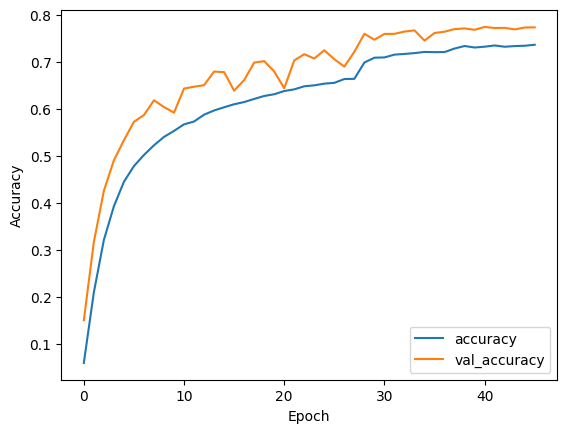

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.8, 1])
plt.legend(loc='lower right')

In [32]:
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)))
model_2.add(layers.MaxPooling2D(pool_size=2, padding="same"))
model_2.add(layers.BatchNormalization())

model_2.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model_2.add(layers.MaxPooling2D(pool_size=2, padding="same"))
model_2.add(layers.BatchNormalization())

model_2.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model_2.add(layers.MaxPooling2D(pool_size=2, padding="same"))
model_2.add(layers.BatchNormalization())

model_2.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu'))
model_2.add(layers.MaxPooling2D(pool_size=2, padding="same"))
model_2.add(layers.BatchNormalization())

model_2.add(layers.Conv2D(128, (7, 7), strides=(1, 1), padding='same', activation='relu'))
model_2.add(layers.MaxPooling2D(pool_size=2, padding="same"))
model_2.add(layers.BatchNormalization())

# model_2.add(layers.Dropout(0.25))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(32, activation='relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Dense(526, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.001)
model_2.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_2.summary()

/Users/akhil/Documents/NEU DAE/Spring24/NeuralNets/Project/bird_image_classifier/nndl_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_114 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_114               │ (None, 112, 112, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_115               │ (None, 56, 56, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_116               │ (None, 28, 28, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 28, 28, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_117               │ (None, 14, 14, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 14, 14, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_118               │ (None, 7, 7, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │       200,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 526)            │        17,358 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 752,142 (2.87 MB)

 Trainable params: 751,438 (2.87 MB)

 Non-trainable params: 704 (2.75 KB)

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./model/cnn_baseline_improved.keras",
        save_best_only=True,
        monitor="val_loss"), 
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.2, 
                                      patience=3, 
                                      min_lr=1e-6),
    keras.callbacks.EarlyStopping(monitor='val_loss', 
                                  verbose=1,
                                  min_delta=0.01,
                                  patience=5)
                                      ]

history_2 = model_2.fit(train_images, epochs=100, 
                    validation_data=val_images, callbacks=callbacks)
model_2.save_weights('./model/cnn_baseline_improved.weights.h5') 

Epoch 1/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 382s 199ms/step - accuracy: 0.0241 - loss: 5.6814 - val_accuracy: 0.1486 - val_loss: 4.1348 - learning_rate: 0.0010
Epoch 2/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 374s 195ms/step - accuracy: 0.1562 - loss: 4.1073 - val_accuracy: 0.3366 - val_loss: 3.0013 - learning_rate: 0.0010
Epoch 3/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 362s 189ms/step - accuracy: 0.2928 - loss: 3.2434 - val_accuracy: 0.4123 - val_loss: 2.6200 - learning_rate: 0.0010
Epoch 4/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 362s 189ms/step - accuracy: 0.3727 - loss: 2.8066 - val_accuracy: 0.5046 - val_loss: 2.1591 - learning_rate: 0.0010
Epoch 5/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 362s 189ms/step - accuracy: 0.4281 - loss: 2.5171 - val_accuracy: 0.5302 - val_loss: 2.0423 - learning_rate: 0.0010
Epoch 6/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 361s 188ms/step - accuracy: 0.4624 - loss: 2.3227 - val_accuracy: 0.5540 - val_loss: 1.9139 - learning_rate: 0.0010
Epoch 7/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 362

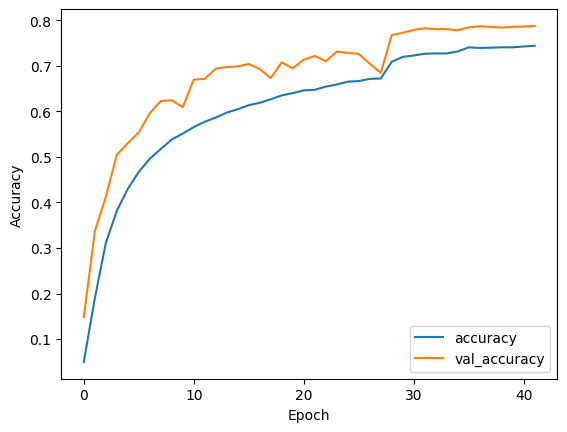

In [35]:
plt.plot(history_2.history['accuracy'], label='accuracy')
plt.plot(history_2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.8, 1])
plt.legend(loc='lower right')

In [4]:
model_3 = models.Sequential()
model_3.add(layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)))
model_3.add(layers.MaxPooling2D(pool_size=2, padding="same"))
model_3.add(layers.BatchNormalization())

model_3.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model_3.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu'))
model_3.add(layers.MaxPooling2D(pool_size=2, padding="same"))
model_3.add(layers.BatchNormalization())

model_3.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu'))
model_3.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation='relu'))
model_3.add(layers.MaxPooling2D(pool_size=2, padding="same"))
model_3.add(layers.BatchNormalization())

model_3.add(layers.Conv2D(128, (7, 7), strides=(1, 1), padding='same', activation='relu'))
model_3.add(layers.Conv2D(128, (7, 7), strides=(2, 2), padding='same', activation='relu'))
model_3.add(layers.MaxPooling2D(pool_size=2, padding="same"))
model_3.add(layers.BatchNormalization())

# model_2.add(layers.Dropout(0.25))

model_3.add(layers.Flatten())
model_3.add(layers.Dense(32, activation='relu'))
model_3.add(layers.BatchNormalization())
model_3.add(layers.Dense(526, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.001)
model_3.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_3.summary()

/Users/akhil/Documents/NEU DAE/Spring24/NeuralNets/Project/bird_image_classifier/nndl_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-13 23:21:08.042650: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-13 23:21:08.042677: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-13 23:21:08.042684: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-13 23:21:08.042704: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-13 23:21:08.042717: I tensorflow/core/common_runtime/pluggable_device/pluggable_dev

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 128)      │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 526)            │        17,358 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,407,406 (5.37 MB)

 Trainable params: 1,406,862 (5.37 MB)

 Non-trainable params: 544 (2.12 KB)

In [5]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./model/cnn_baseline_improved.keras",
        save_best_only=True,
        monitor="val_loss"), 
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.75, 
                                      patience=3, 
                                      min_lr=1e-6),
    keras.callbacks.EarlyStopping(monitor='val_loss', 
                                  verbose=1,
                                  min_delta=0.01,
                                  patience=5)
                                      ]

history_3 = model_3.fit(train_images, epochs=100, 
                    validation_data=val_images, callbacks=callbacks)
model_3.save_weights('./model/cnn_baseline_improved.weights.h5') 

Epoch 1/100


2024-04-13 23:21:11.018419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/akhil/Documents/NEU DAE/Spring24/NeuralNets/Project/bird_image_classifier/nndl_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1911/1911 ━━━━━━━━━━━━━━━━━━━━ 356s 184ms/step - accuracy: 0.0171 - loss: 5.8178 - val_accuracy: 0.1078 - val_loss: 4.4102 - learning_rate: 0.0010
Epoch 2/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 356s 186ms/step - accuracy: 0.1241 - loss: 4.2904 - val_accuracy: 0.2799 - val_loss: 3.2694 - learning_rate: 0.0010
Epoch 3/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 360s 188ms/step - accuracy: 0.2558 - loss: 3.4112 - val_accuracy: 0.4041 - val_loss: 2.6359 - learning_rate: 0.0010
Epoch 4/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 356s 186ms/step - accuracy: 0.3505 - loss: 2.8828 - val_accuracy: 0.4614 - val_loss: 2.3328 - learning_rate: 0.0010
Epoch 5/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 359s 187ms/step - accuracy: 0.4176 - loss: 2.5361 - val_accuracy: 0.5133 - val_loss: 2.0691 - learning_rate: 0.0010
Epoch 6/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 360s 188ms/step - accuracy: 0.4537 - loss: 2.3298 - val_accuracy: 0.5246 - val_loss: 2.0186 - learning_rate: 0.0010
Epoch 7/100
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 358s 187ms/step

KeyboardInterrupt: 